# Matching q=NF to p=Normal by minimizing KL(q|p)

In [20]:
%load_ext autoreload
%autoreload 2
%pip install -q torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch

from torch.distributions import MultivariateNormal


In [22]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    ENV = torch.cuda
    print("Using GPU")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    ENV = torch
    print("Using CPU")

Using CPU


In [23]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (5, 5) # Width and height

In [24]:
import sys
sys.path.append("../")

In [25]:
import reparametrized as r
from reparametrized import sampling
from reparametrized import densities

## Dimensionality

In [26]:
parameter_shape = (6, )  # parameters dimensionality

# some samplers initialize with this value; others just match its shape
parameter_init_value = torch.randn(torch.Size(parameter_shape))  

## Create target p

In [27]:
# calc_p_nll = densities.create_gaussian_nll(parameter_shape)  # factorized Normal(0, I)

Custom full-rank Gaussian target:

In [28]:
t = torch.tensor(range(parameter_shape[0]))*3.
cov = t[None,:]*t[:,None]+300*torch.eye(parameter_shape[0])
for i, j in [(1, 3), (5, 3)]:
    cov[i, j] = -cov[i, j]
    cov[j, i] = -cov[j, i]
loc = torch.tensor(range(parameter_shape[0], 0, -1))*2.
p = MultivariateNormal(loc=loc, covariance_matrix=cov)

def calc_p_nll(samples):
    return -p.log_prob(samples)

In [29]:
loc, cov

(tensor([12., 10.,  8.,  6.,  4.,  2.]),
 tensor([[ 300.,    0.,    0.,    0.,    0.,    0.],
         [   0.,  309.,   18.,  -27.,   36.,   45.],
         [   0.,   18.,  336.,   54.,   72.,   90.],
         [   0.,  -27.,   54.,  381.,  108., -135.],
         [   0.,   36.,   72.,  108.,  444.,  180.],
         [   0.,   45.,   90., -135.,  180.,  525.]]))

## Create q

In [30]:
sampler, variational_params, aux_objs = sampling.create_flow_sampler(parameter_init_value, 
                                                                     realnvp_m=8,  # change default parameters!
                                                                     realnvp_num_layers=16,
                                                                     rezero_trick=False,  # seems to work better with random initialization
                                                                     )

In [31]:
# Preview variational parameters:
{n: p.shape for n, p in variational_params.items()}

{'t.0.0.weight': torch.Size([8, 3]),
 't.0.0.bias': torch.Size([8]),
 't.0.2.weight': torch.Size([8, 8]),
 't.0.2.bias': torch.Size([8]),
 't.0.4.weight': torch.Size([3, 8]),
 't.0.4.bias': torch.Size([3]),
 't.1.0.weight': torch.Size([8, 3]),
 't.1.0.bias': torch.Size([8]),
 't.1.2.weight': torch.Size([8, 8]),
 't.1.2.bias': torch.Size([8]),
 't.1.4.weight': torch.Size([3, 8]),
 't.1.4.bias': torch.Size([3]),
 't.2.0.weight': torch.Size([8, 3]),
 't.2.0.bias': torch.Size([8]),
 't.2.2.weight': torch.Size([8, 8]),
 't.2.2.bias': torch.Size([8]),
 't.2.4.weight': torch.Size([3, 8]),
 't.2.4.bias': torch.Size([3]),
 't.3.0.weight': torch.Size([8, 3]),
 't.3.0.bias': torch.Size([8]),
 't.3.2.weight': torch.Size([8, 8]),
 't.3.2.bias': torch.Size([8]),
 't.3.4.weight': torch.Size([3, 8]),
 't.3.4.bias': torch.Size([3]),
 't.4.0.weight': torch.Size([8, 3]),
 't.4.0.bias': torch.Size([8]),
 't.4.2.weight': torch.Size([8, 8]),
 't.4.2.bias': torch.Size([8]),
 't.4.4.weight': torch.Size([3, 8]

## Preview before optimization

In [32]:
samples, nlls = sampler(n_samples=10240)
samples.shape, nlls.shape

(torch.Size([10240, 6]), torch.Size([10240]))

In [33]:
# Means, variances, covariance matrix:
samples.mean(0), samples.std(0)**2, torch.cov(samples.T).round(decimals=2)

(tensor([-1.5947,  0.1214,  0.4272, -0.5988, -0.5400,  0.3610],
        grad_fn=<MeanBackward1>),
 tensor([1.8522, 1.2888, 1.8380, 0.2075, 7.6668, 4.4731],
        grad_fn=<PowBackward0>),
 tensor([[ 1.8500,  0.0500, -0.0400, -0.0100, -0.4600, -0.0800],
         [ 0.0500,  1.2900,  0.0500,  0.0200, -0.5400,  0.1900],
         [-0.0400,  0.0500,  1.8400,  0.0200,  0.1100,  0.2600],
         [-0.0100,  0.0200,  0.0200,  0.2100, -0.0000,  0.0500],
         [-0.4600, -0.5400,  0.1100, -0.0000,  7.6700,  0.2600],
         [-0.0800,  0.1900,  0.2600,  0.0500,  0.2600,  4.4700]],
        grad_fn=<RoundBackward1>))

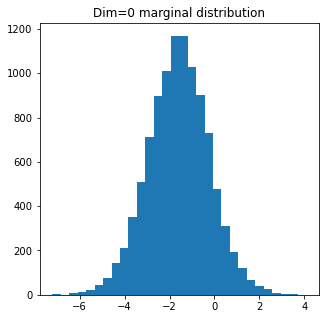

In [34]:
plt.hist(samples[:,0].cpu().detach().numpy(), bins=30);
plt.title("Dim=0 marginal distribution");

## Optimize

In [35]:
optimized_parameters = variational_params.values()
optimizer = torch.optim.Adam(optimized_parameters, lr=0.001) 
n_epochs = 5000
n_posterior_samples = 1

for e in range(n_epochs):
    optimizer.zero_grad()

    samples, q_nlls = sampler(n_samples=n_posterior_samples)
    p_nlls = calc_p_nll(samples)
    KLD = p_nlls-q_nlls

    loss_vi = KLD.mean()
    loss_vi.backward()
    optimizer.step()

    if (e<100 and e%10==0) or e%500==0:
        samples, q_nlls = sampler(n_samples=10240)  # let use  more samples to estimate reported KLD
        p_nlls = calc_p_nll(samples)
        KLD = p_nlls-q_nlls

        print(f"epoch={e}: loss={KLD.mean(): .2f}")

epoch=0: loss= 13.78
epoch=10: loss= 12.43
epoch=20: loss= 10.92
epoch=30: loss= 9.39
epoch=40: loss= 7.77
epoch=50: loss= 7.11
epoch=60: loss= 6.16
epoch=70: loss= 5.27
epoch=80: loss= 5.23
epoch=90: loss= 5.10
epoch=500: loss= 1.90
epoch=1000: loss= 0.86
epoch=1500: loss= 0.52
epoch=2000: loss= 0.41
epoch=2500: loss= 0.36
epoch=3000: loss= 0.39
epoch=3500: loss= 0.31
epoch=4000: loss= 0.21
epoch=4500: loss= 0.28


## Preview after optimization

In [36]:
samples, nlls = sampler(n_samples=102400)

# Means, variances, covariance matrix:
samples.mean(0), samples.std(0)**2, torch.cov(samples.T).round(decimals=0)

(tensor([15.0908,  9.0118,  8.4630,  6.1885,  4.4680,  2.7966],
        grad_fn=<MeanBackward1>),
 tensor([450.3158, 346.1013, 331.7757, 394.6595, 355.8696, 443.4500],
        grad_fn=<PowBackward0>),
 tensor([[450.,  33.,  37.,   2.,  42.,  21.],
         [ 33., 346.,  67.,  -3.,  32.,  50.],
         [ 37.,  67., 332.,  53.,  22., 108.],
         [  2.,  -3.,  53., 395.,  71., -79.],
         [ 42.,  32.,  22.,  71., 356.,  86.],
         [ 21.,  50., 108., -79.,  86., 443.]], grad_fn=<RoundBackward1>))

In [37]:
# target:
loc, cov 

(tensor([12., 10.,  8.,  6.,  4.,  2.]),
 tensor([[ 300.,    0.,    0.,    0.,    0.,    0.],
         [   0.,  309.,   18.,  -27.,   36.,   45.],
         [   0.,   18.,  336.,   54.,   72.,   90.],
         [   0.,  -27.,   54.,  381.,  108., -135.],
         [   0.,   36.,   72.,  108.,  444.,  180.],
         [   0.,   45.,   90., -135.,  180.,  525.]]))

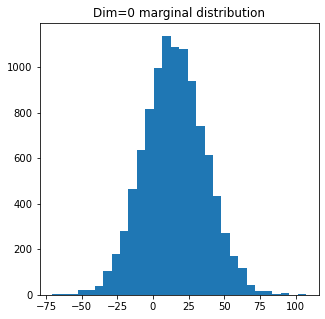

In [38]:
samples, nlls = sampler(n_samples=10240)
plt.hist(samples[:, 0].cpu().detach().numpy(), bins=30);
plt.title("Dim=0 marginal distribution");